In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense,Conv1D,AveragePooling1D,Flatten,Dropout
from tensorflow.keras import Sequential, optimizers
from tensorflow import math
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

!wget https://github.com/hammerscope/artifacts/raw/main/website_fingerprinting/hammerscope_website_fingerprinting_data.csv
!wget https://github.com/hammerscope/artifacts/raw/main/website_fingerprinting/rapl_website_fingerprinting_data.csv

--2022-02-06 09:52:06--  https://github.com/hammerscope/artifacts/raw/main/website_fingerprinting/hammerscope_website_fingerprinting_data.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hammerscope/artifacts/main/website_fingerprinting/hammerscope_website_fingerprinting_data.csv [following]
--2022-02-06 09:52:06--  https://raw.githubusercontent.com/hammerscope/artifacts/main/website_fingerprinting/hammerscope_website_fingerprinting_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7259456 (6.9M) [text/plain]
Saving to: ‘hammerscope_website_fingerprinting_data.csv’

hammerscope_website

In [2]:
def get_conv(vector_len,n_classes):
    n_filters=64 # 8,16,32,64,128, might be different between layers
    kernel_size=32 #2,4,8,16,32, might be different between layers
    pool_size=4 # 2,3,4, might be different between layers

    model=Sequential()
    model.add(Conv1D(filters=n_filters,kernel_size=kernel_size,padding='same',activation='relu',input_shape=(vector_len,1)))
    model.add(AveragePooling1D(pool_size=pool_size,padding='same'))
    model.add(Conv1D(filters=n_filters,kernel_size=kernel_size,padding='same',activation='relu'))
    model.add(AveragePooling1D(pool_size=pool_size,padding='same'))
    model.add(Conv1D(filters=int(n_filters*2),kernel_size=kernel_size,padding='same',activation='relu'))
    model.add(AveragePooling1D(pool_size=pool_size,padding='same'))
    model.add(Flatten())
    model.add(Dense(units=50,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=50,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=n_classes,activation='softmax'))

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3)
                    ,loss='sparse_categorical_crossentropy',metrics='accuracy')
    return model


In [3]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

In [4]:
#Hammerscope data
data=pd.read_csv('hammerscope_website_fingerprinting_data.csv',header=None)
le=LabelEncoder()
y=le.fit_transform(data.pop(721))
x=data.values.reshape(-1, 721)

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []
  
for train_index, test_index in skf.split(x, y):
    x_train_fold, x_test_fold = x[train_index], x[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model=get_conv(721,25)
    model.fit(x_train_fold, y_train_fold, epochs=30, verbose=0)
    evl=model.evaluate(x_test_fold, y_test_fold)[1]
    predictions = model.predict(x_test_fold)
    lst_accu_stratified.append(evl)
    print(evl)

sum(lst_accu_stratified)/5
  

16/16 [==============================] - 1s 53ms/step - loss: 1.6799 - accuracy: 0.4143
0.41434264183044434
16/16 [==============================] - 1s 53ms/step - loss: 1.9031 - accuracy: 0.4064
0.4063745141029358
16/16 [==============================] - 1s 51ms/step - loss: 1.9169 - accuracy: 0.3725
0.3725099563598633
16/16 [==============================] - 1s 53ms/step - loss: 1.7654 - accuracy: 0.4192
0.41916167736053467
16/16 [==============================] - 1s 53ms/step - loss: 1.8752 - accuracy: 0.3892
0.38922154903411865


0.40032206773757933

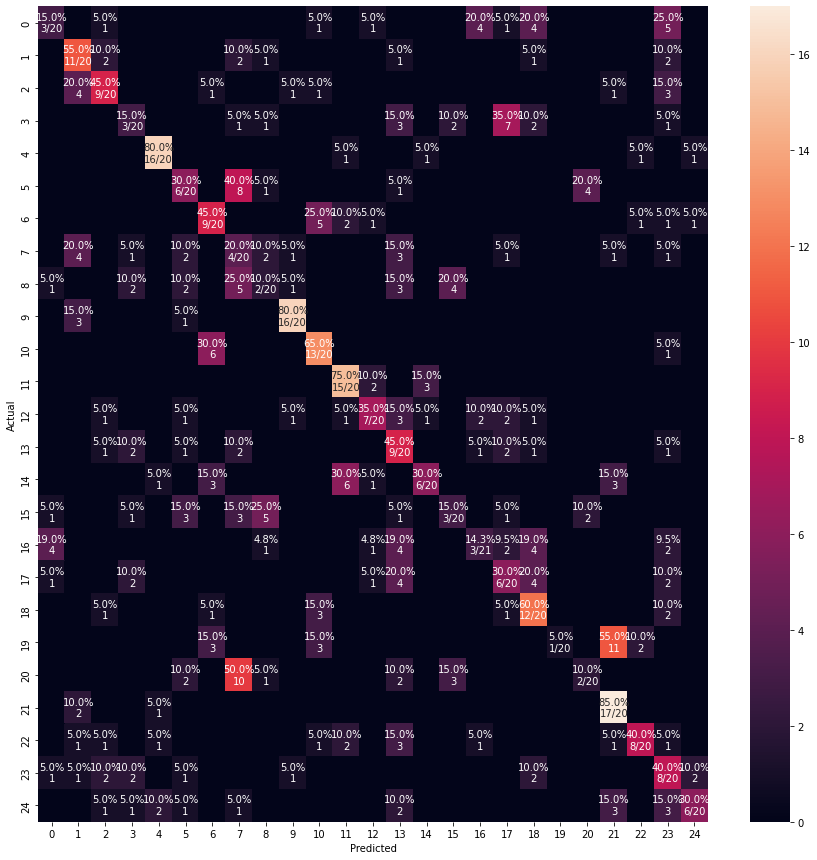

In [6]:
y_classes = predictions.argmax(axis=-1)
cm_analysis(y_test_fold, y_classes, range(25), ymap=None, figsize=(15,15))

In [7]:
#RAPL data
data=pd.read_csv('rapl_website_fingerprinting_data.csv',header=None)
le=LabelEncoder()
y=le.fit_transform(data.pop(720))
x=data.values.reshape(-1, 720)

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []
  
for train_index, test_index in skf.split(x, y):
    x_train_fold, x_test_fold = x[train_index], x[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model=get_conv(720,25)
    model.fit(x_train_fold, y_train_fold, epochs=30, verbose=0)
    evl=model.evaluate(x_test_fold, y_test_fold)[1]
    predictions = model.predict(x_test_fold)
    lst_accu_stratified.append(evl)
    print(evl)

sum(lst_accu_stratified)/5

16/16 [==============================] - 1s 53ms/step - loss: 3.2189 - accuracy: 0.0398
0.039840638637542725
16/16 [==============================] - 1s 52ms/step - loss: 3.2189 - accuracy: 0.0398
0.039840638637542725
16/16 [==============================] - 1s 52ms/step - loss: 3.2189 - accuracy: 0.0398
0.039840638637542725
16/16 [==============================] - 1s 53ms/step - loss: 3.2189 - accuracy: 0.0399
0.03992015868425369
16/16 [==============================] - 1s 52ms/step - loss: 3.2189 - accuracy: 0.0399
0.03992015868425369


0.03987244665622711

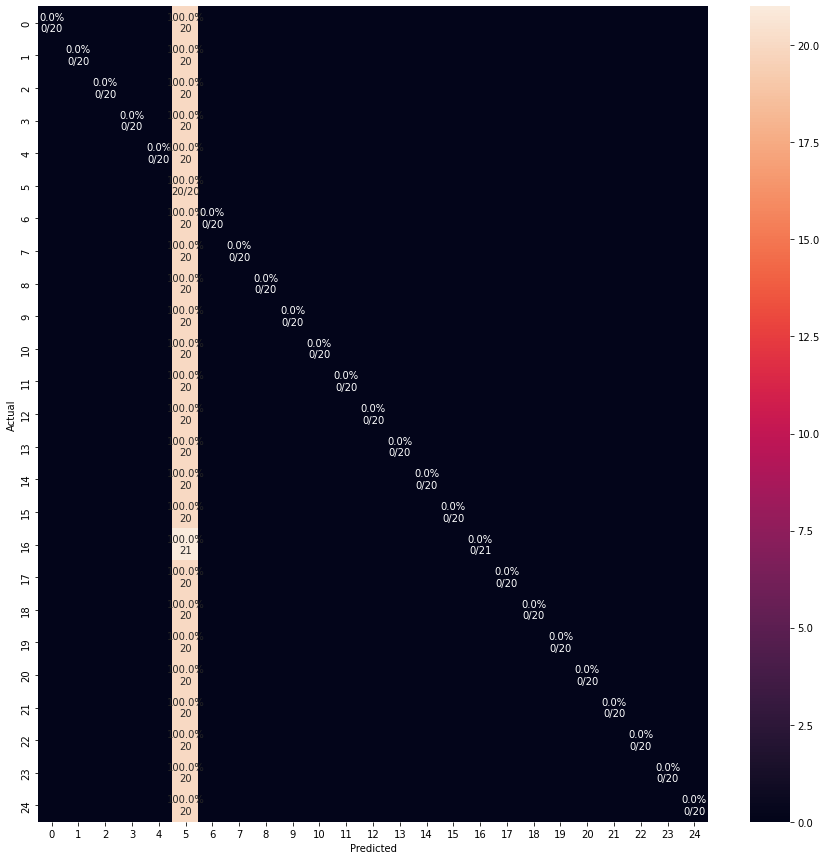

In [9]:
y_classes = predictions.argmax(axis=-1)
cm_analysis(y_test_fold, y_classes, range(25), ymap=None, figsize=(15,15))